# Coefficient variable for crypto assets

In [1]:
import os
import time
import json
import datetime
import requests
import numpy as np
import pandas as pd

headers = {'Content-Type': 'application/json'}
api_url_base_coingecko = 'https://api.coingecko.com/api/v3/coins/'
vs_currency = 'usd'
days = '30'

In [2]:
def getCoinData(ids, vs, days):
    api_url_coingecko = '{0}/{1}/ohlc?vs_currency={2}&days={3}'.format(api_url_base_coingecko, ids, vs, days)
    res = requests.get(api_url_coingecko, headers=headers)

    if res.status_code == 200:
        df = pd.read_json(res.content.decode('utf-8'))
        df.columns = ['timestamp', 'Open', 'High', 'Low', 'Close']
        df['timestamp'] = df['timestamp']/1000
        df['timestamp'] = df['timestamp'].astype(int)
        df['timestamp'] = df['timestamp'].map(datetime.datetime.utcfromtimestamp)
        df.index = df['timestamp']
        feature_name = ['Close']
        df = df[feature_name]
        df.interpolate(limit_direction='both', inplace=True)
        df.columns = [ids]
        return df
    else:
        return None

In [3]:
coins = ['bitcoin', 'ethereum', 'chainlink', 'ripple', 'litecoin', 'polkadot']
df = pd.DataFrame()
for coin in coins:
    df = pd.concat([df, getCoinData(coin, vs_currency, days)], axis=1, sort=True, join='outer')

In [4]:
df.head()

,bitcoin,ethereum,chainlink,ripple,litecoin,polkadot
timestamp,,,,,,
2020-10-07 12:00:00,10616.74,339.77,8.67,0.245568,45.68,3.75
2020-10-07 16:00:00,10633.94,340.68,8.83,0.248428,46.13,3.80
2020-10-07 20:00:00,10663.21,341.73,8.92,0.249665,46.76,3.83
2020-10-08 00:00:00,10662.60,340.32,8.88,0.248464,46.59,3.84
2020-10-08 04:00:00,10643.29,339.17,8.83,0.247561,46.28,3.83


In [5]:
df_ = df.copy()
for coin in coins:
    df_[coin] = df[coin].diff().fillna(method='bfill')
df_.head()

,bitcoin,ethereum,chainlink,ripple,litecoin,polkadot
timestamp,,,,,,
2020-10-07 12:00:00,17.20,0.91,0.16,0.002860,0.45,0.05
2020-10-07 16:00:00,17.20,0.91,0.16,0.002860,0.45,0.05
2020-10-07 20:00:00,29.27,1.05,0.09,0.001237,0.63,0.03
2020-10-08 00:00:00,-0.61,-1.41,-0.04,-0.001201,-0.17,0.01
2020-10-08 04:00:00,-19.31,-1.15,-0.05,-0.000903,-0.31,-0.01


In [6]:
# statistics
df_.describe()

,bitcoin,ethereum,chainlink,ripple,litecoin,polkadot
count,181.000000,181.000000,181.000000,181.000000,181.000000,181.000000
mean,26.598453,0.538840,0.016022,0.000064,0.088729,0.003978
std,115.819809,4.415849,0.205809,0.002174,0.743924,0.071645
min,-484.820000,-13.150000,-0.420000,-0.005985,-2.610000,-0.190000
25%,-17.230000,-1.410000,-0.120000,-0.001182,-0.270000,-0.040000
50%,17.200000,0.650000,0.010000,-0.000128,0.040000,0.000000
75%,70.760000,2.330000,0.130000,0.001140,0.420000,0.040000
max,550.540000,19.860000,0.730000,0.008927,3.220000,0.330000


In [7]:
import matplotlib.pyplot as plt
import seaborn as sns

/opt/conda/lib/python3.7/site-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


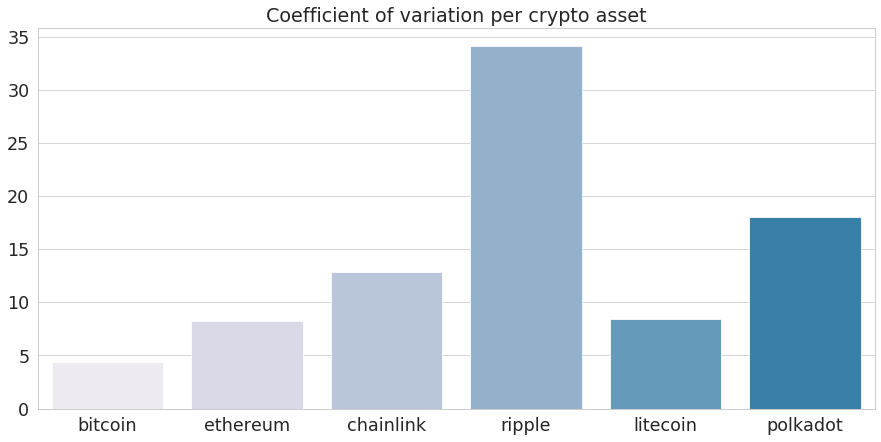

In [8]:
now = datetime.datetime.utcnow()
path = 'data/' + 'coefficientVariable_' + now.strftime('%Y%m%d_%H%M%S') + '.png'

# seaborn drawing
sns.set_style('whitegrid')
sns.set_palette("PuBu", 8)
sns.set_context(context='paper', font_scale=2, rc=None)

# Coefficient of variation per asset
fig = plt.figure(figsize=(15, 7))
ax = fig.add_subplot(1, 1, 1)

# calculate coefficient variance,
# represents the ratio of the standard deviation to the mean
cv = pd.DataFrame(df_.std()/df_.mean())
cv.columns = ['Coef']
ax.set_title('Coefficient of variation per crypto asset')
sns_plot = sns.barplot(data=cv.T)
figure = sns_plot.get_figure()
figure.savefig(path)